In [33]:
#Importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import requests
import missingno as msno
import warnings


from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact, interactive, fixed, interact_manual
from io import StringIO
import gdown

warnings.filterwarnings('ignore')

In [34]:
import matplotlib.pyplot as plt

def plot_well_logs(df, well, lithology_col, colors,lithology,dz=100,figsize=(9,12)):
    fig, axes = plt.subplots(1, 5, figsize=figsize)

    # Definindo o limite vertical e adicionando grade
    for ax in axes:
        ax.set_ylim(df[df.WELL == well].DEPTH_MD.max() + dz, df[df.WELL == well].DEPTH_MD.min() - dz)
        ax.grid()

    # Primeiro gráfico: GR com CALI
    axes[0].plot(df[df.WELL == well].GR, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='GR')
    ax0 = axes[0].twiny()
    ax0.plot(df[df.WELL == well].CALI, df[df.WELL == well].DEPTH_MD, c='r', ls='--', lw=0.8, label='CALI')
    ax0.legend(loc='upper left', fontsize=8)

    # Segundo gráfico: RDEP e RMED
    axes[1].plot(df[df.WELL == well].RDEP, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='RILD')
    axes[1].plot(df[df.WELL == well].RMED, df[df.WELL == well].DEPTH_MD, color='red', lw=0.8, label='RILM', ls='--')
    axes[1].set_xscale('log')

    # Terceiro gráfico: DTC
    axes[2].plot(df[df.WELL == well].DTC, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='DTC')

    # Quarto gráfico: RHOB com NPHI
    axes[3].plot(df[df.WELL == well].RHOB, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='RHOB')
    ax3 = axes[3].twiny()
    ax3.plot(df[df.WELL == well].NPHI, df[df.WELL == well].DEPTH_MD, color='red', lw=0.8, label='NPHI', ls='--')


    for i,j in zip(lithology,colors):

        axes[4].fill_betweenx(df[df.WELL == well].DEPTH_MD, 0,
                           1,
                           where=(df[df.WELL == well][lithology_col] == i),
                           color=j, alpha=1,label=i)

    # Adicionando legendas em todos os gráficos
    for ax in axes:
        ax.legend(fontsize=8, loc='upper right')

    axes[4].legend(fontsize=5)

    # Ajustando o layout para evitar sobreposição
    fig.tight_layout()

    return fig, axes

In [35]:
colors = [
    "#fcf444",  # light yellow/pastel yellow
    "#84fc04",  # lime green / neon green
    "#84b4b4",  # blue-green
    "#340cfc",  # deep blue / electric blue
    "#046ccc",  # cyan blue
    "#c0fcfc",  # light cyan
    "#88fcfc",  # very light cyan / soft turquoise
    "#6cb4cc",  # light sky blue / light cerulean blue
    "#dc1cfc",  # bright magenta / electric purple
    "#1005bc",  # deep blue
    "#dedede",  # light gray
    "#fc0c34"   # gainsboro
]

lithology = [
    "Sandstone (Arenito)",
    "Sandstone/Shale (Arenito)",
    "Shale (Argilito)",
    "Marl (Marga)",
    "Dolomite (Dolomita)",
    "Limestone (Calcário)",
    "Chalk (Giz)",
    "Halite (Halita)",
    "Anhydrite (Anidrita)",
    "Tuff (Tufo)",
    "Coal (Carvão)",
    "Basement (Substrato)"
]

| Código  | Litologia                          
|---------|------------------------------------
| 30000   | Sandstone (Arenito)                
| 65030   | Sandstone/Shale (Arenito/Argilito)
| 65000   | Shale (Argilito)                       
| 80000   | Marl (Marga)                       
| 74000   | Dolomite (Dolomita)                
| 70000   | Limestone (Calcário)               
| 70032   | Chalk (Giz)                        
| 88000   | Halite (Halita)                    
| 86000   | Anhydrite (Anidrita)               
| 99000   | Tuff (Tufo)                        
| 90000   | Coal (Carvão)                      
| 93000   | Basement (Substrato)               


In [36]:
# URL de download do drive
url = 'https://drive.google.com/uc?export=download&id=1u6_1ZMPIDy-agKZnKVUCp0t0bvK8ccPC'

In [39]:
#Fazendo o download do arquivo para pasta do drive
gdown.download(url, '/content/drive/MyDrive/train.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1u6_1ZMPIDy-agKZnKVUCp0t0bvK8ccPC
To: /content/drive/MyDrive/train.csv
100%|██████████| 89.6M/89.6M [00:00<00:00, 151MB/s]


'/content/drive/MyDrive/train.csv'

In [40]:
df = pd.read_csv('train.csv')

df.info() #informações sobre o dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746575 entries, 0 to 746574
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WELL                              746575 non-null  object 
 1   DEPTH_MD                          746575 non-null  float64
 2   CALI                              708506 non-null  float64
 3   RMED                              724221 non-null  float64
 4   RDEP                              738413 non-null  float64
 5   RHOB                              622971 non-null  float64
 6   GR                                746575 non-null  float64
 7   NPHI                              425137 non-null  float64
 8   DTC                               692120 non-null  float64
 9   FORCE_2020_LITHOFACIES_LITHOLOGY  746575 non-null  int64  
 10  GROUP                             746497 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 62.

In [41]:
#Todos os poços tem medidas nulas
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 384968 entries, 4238 to 746574
Data columns (total 11 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WELL                              384968 non-null  object 
 1   DEPTH_MD                          384968 non-null  float64
 2   CALI                              384968 non-null  float64
 3   RMED                              384968 non-null  float64
 4   RDEP                              384968 non-null  float64
 5   RHOB                              384968 non-null  float64
 6   GR                                384968 non-null  float64
 7   NPHI                              384968 non-null  float64
 8   DTC                               384968 non-null  float64
 9   FORCE_2020_LITHOFACIES_LITHOLOGY  384968 non-null  int64  
 10  GROUP                             384968 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 35.2+

In [42]:
#Verificando número de poços
print(f"Número de poços disponíveis: {len(df.WELL.unique())}")

Número de poços disponíveis: 40


In [43]:
#Criando novas variáveis a partir das variáveis categoricas
LabelEncoder_form = LabelEncoder()
LabelEncoder_group = LabelEncoder()

LabelEncoder_form.fit(df['GROUP'])

df['GROUP_num'] = LabelEncoder_form.transform(df['GROUP'])

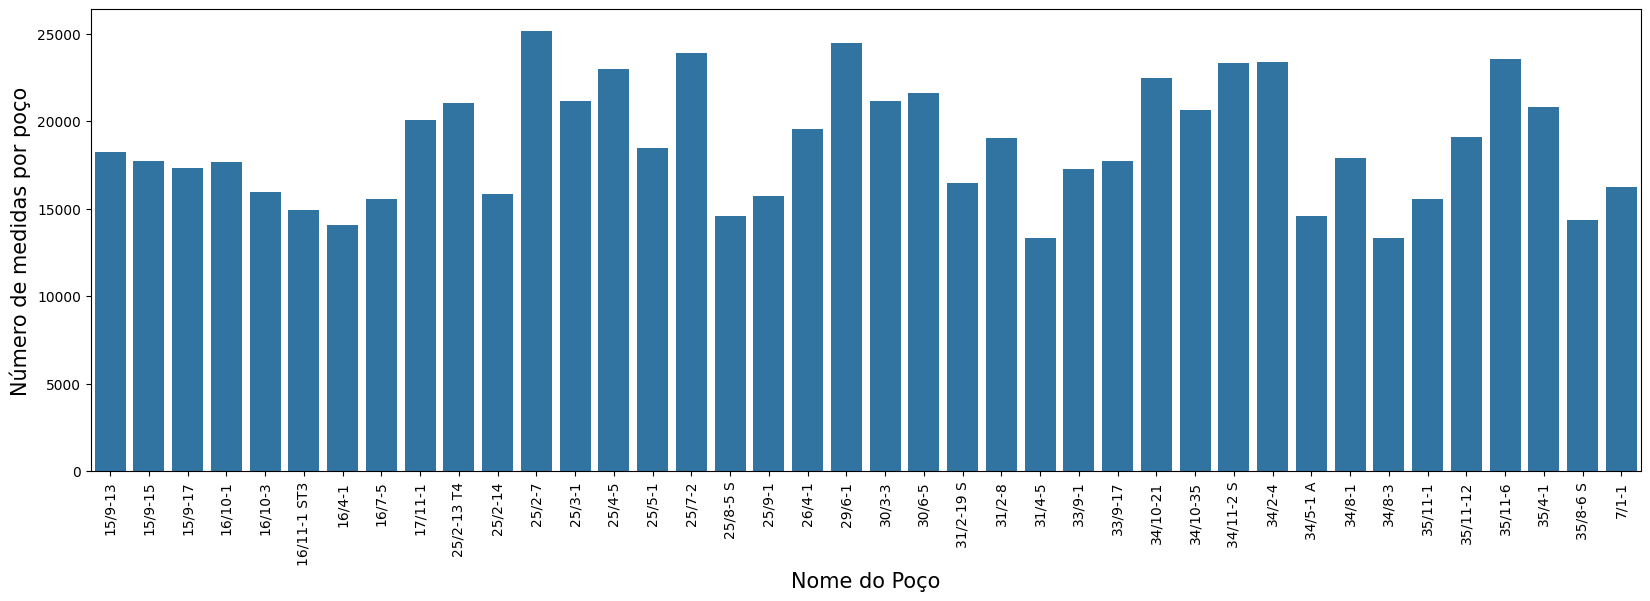

In [44]:
#Plotando um countplot para verificar o número de medidas de cada poço na vertical

fig,axes=plt.subplots(figsize=(20,6))
sns.countplot(x='WELL',data=df,ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_xlabel('Nome do Poço',fontsize=15)
axes.set_ylabel('Número de medidas por poço',fontsize=15)
fig.show()

<Axes: >

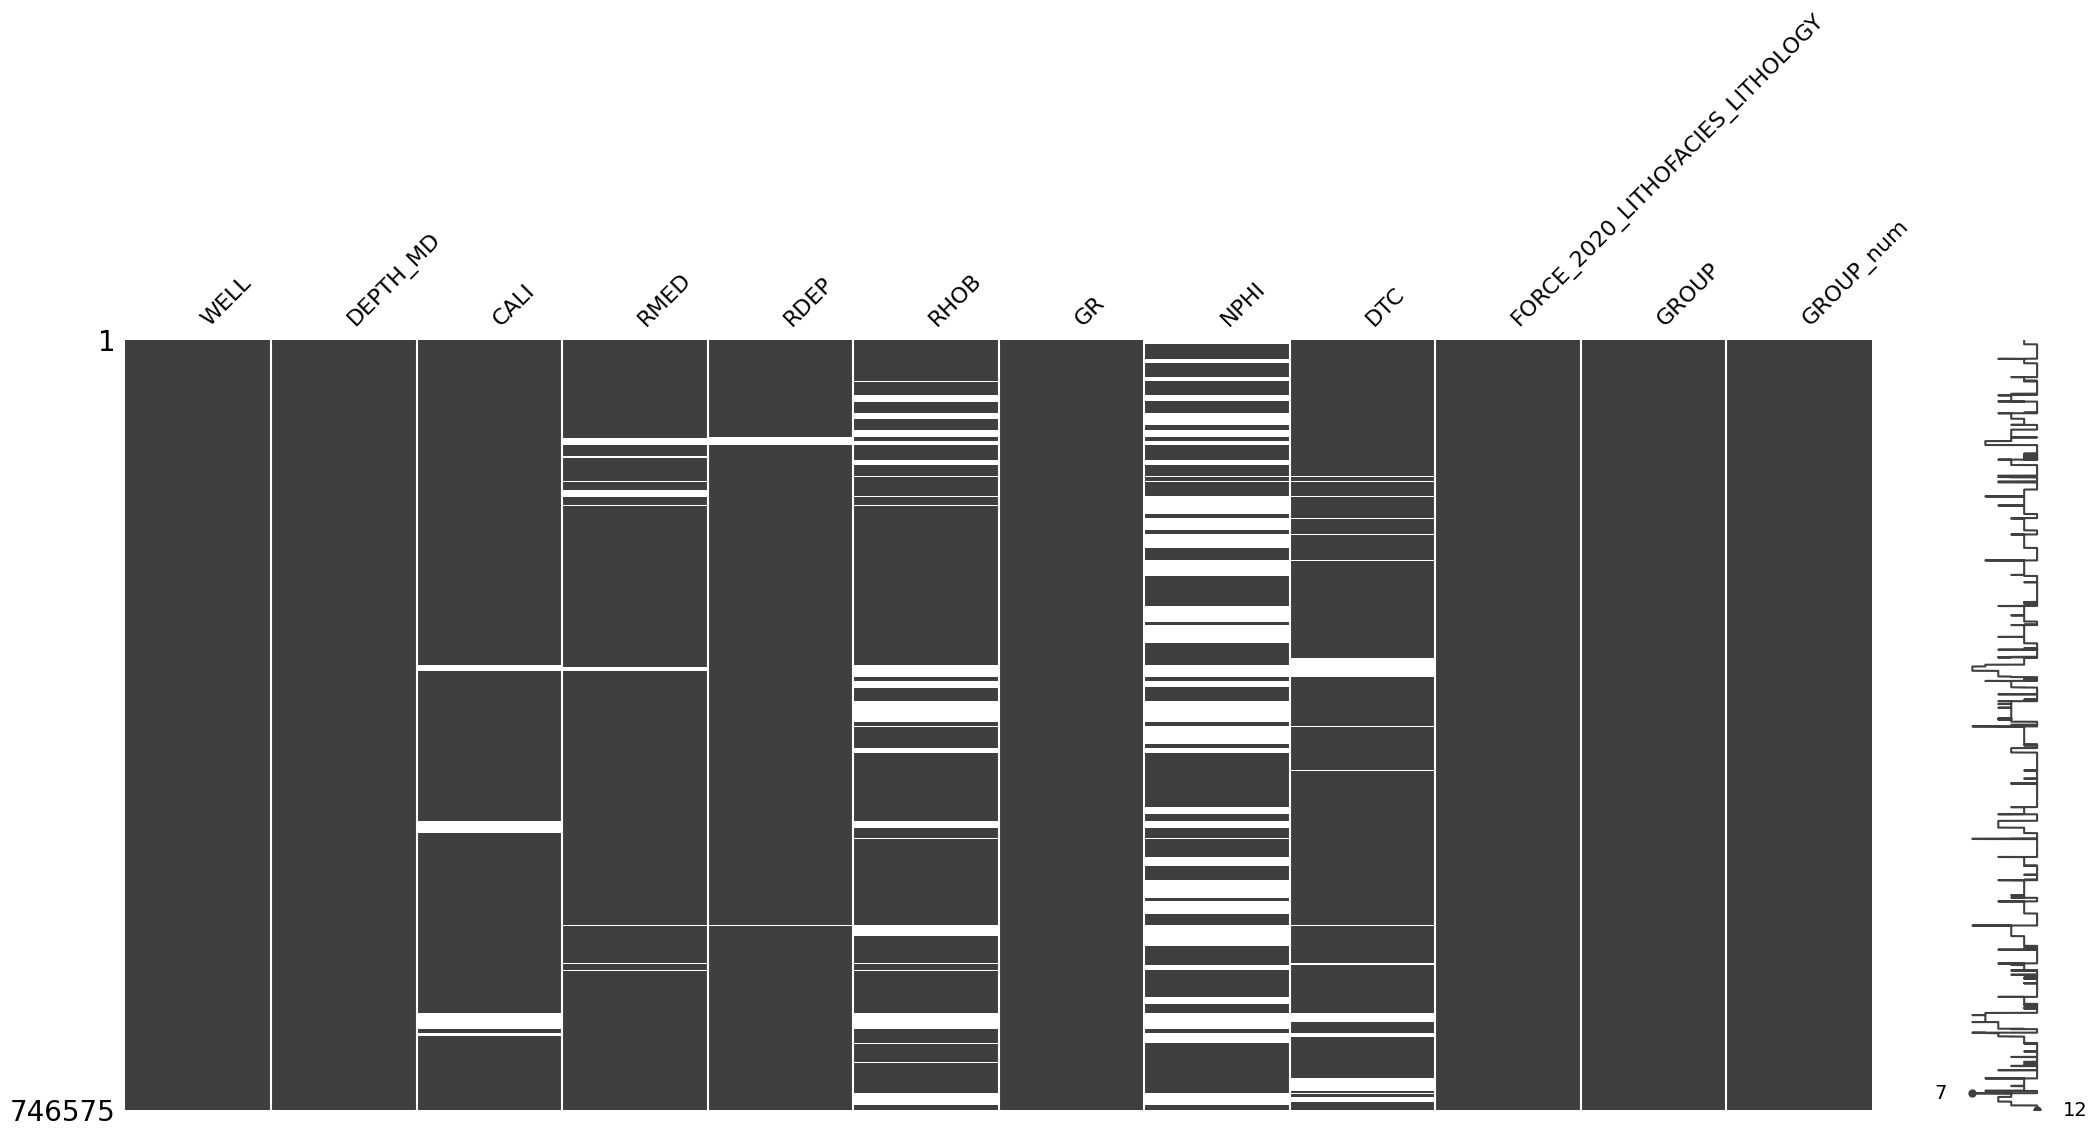

In [45]:
msno.matrix(df)

In [46]:
# dropando valores nulos
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384968 entries, 4238 to 746574
Data columns (total 12 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   WELL                              384968 non-null  object 
 1   DEPTH_MD                          384968 non-null  float64
 2   CALI                              384968 non-null  float64
 3   RMED                              384968 non-null  float64
 4   RDEP                              384968 non-null  float64
 5   RHOB                              384968 non-null  float64
 6   GR                                384968 non-null  float64
 7   NPHI                              384968 non-null  float64
 8   DTC                               384968 non-null  float64
 9   FORCE_2020_LITHOFACIES_LITHOLOGY  384968 non-null  int64  
 10  GROUP                             384968 non-null  object 
 11  GROUP_num                         384968 non-null  int

In [47]:
#Criação de uma coluna com o nome das litologias
lithology_map = {
    30000: 'Sandstone (Arenito)',
    65030: 'Sandstone/Shale (Arenito/Argilito)',
    65000: 'Shale (Argilito)',
    80000: 'Marl (Marga)',
    74000: 'Dolomite (Dolomita)',
    70000: 'Limestone (Calcário)',
    70032: 'Chalk (Giz)',
    88000: 'Halite (Halita)',
    86000: 'Anhydrite (Anidrita)',
    99000: 'Tuff (Tufo)',
    90000: 'Coal (Carvão)',
    93000: 'Basement (Substrato)'
}
df['LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].apply(lambda x: lithology_map.get(x, 'Unknown'))
df.head()

,WELL,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP,GROUP_num,LITHOLOGY
4238,15/9-13,1138.704,19.322735,1.013309,1.091499,1.774626,55.892757,0.765867,147.837677,30000,NORDLAND GP.,6,Sandstone (Arenito)
4239,15/9-13,1138.856,18.613674,1.088184,1.122706,1.800986,60.929138,0.800262,142.382431,65000,NORDLAND GP.,6,Shale (Argilito)
4240,15/9-13,1139.008,18.212072,1.127155,1.148141,1.817696,62.117264,0.765957,138.258331,65000,NORDLAND GP.,6,Shale (Argilito)
4241,15/9-13,1139.160,18.134182,1.141467,1.170984,1.829333,61.010860,0.702521,139.198914,65000,NORDLAND GP.,6,Shale (Argilito)
4242,15/9-13,1139.312,18.033762,1.138007,1.184080,1.813854,58.501236,0.639708,144.290085,65000,NORDLAND GP.,6,Shale (Argilito)


interactive(children=(Dropdown(description='well', options=('15/9-13', '15/9-15', '15/9-17', '16/10-1', '16/10…

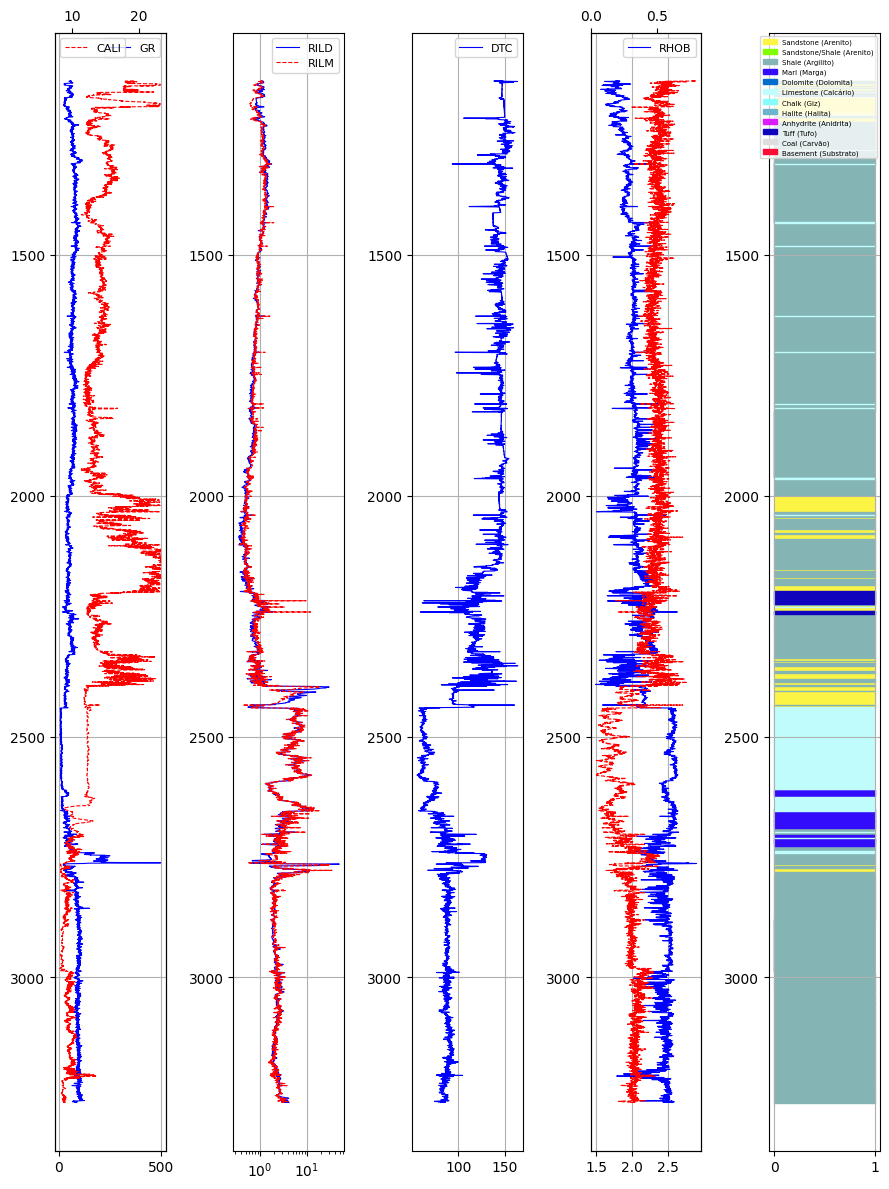

In [48]:
@interact(well=df.WELL.unique())
def update_well_plot(well):
    plot_well_logs(df, well=well,lithology_col='LITHOLOGY',colors=colors,lithology=lithology,dz=100)

In [49]:
#Selecionando aleatóriamente 5 poços para serem selecionados como blind e o restante para realizar a aplicação

well_names = df.WELL.isin(np.random.choice(df.WELL.unique(),size=5))

blind = df[well_names]
dataset = df[~well_names]

print(f'Número de amostras separadas para o treino: {len(dataset)}\nNúmero de amostras separadas para o teste cego: {len(blind)}')
print(f'Propoção Teste cego / Treino: {len(blind)/len(dataset)*100:.2f}%')

Número de amostras separadas para o treino: 329663
Número de amostras separadas para o teste cego: 55305
Propoção Teste cego / Treino: 16.78%


In [50]:
dataset.describe()

,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP_num
count,329663.000000,329663.000000,329663.000000,329663.000000,329663.000000,329663.000000,329663.000000,329663.000000,329663.000000,329663.000000
mean,2668.519529,12.091373,5.030846,4.656982,2.345434,74.437589,0.337251,103.518438,61337.539596,6.443881
std,914.961785,3.104675,30.076454,34.682765,0.242102,34.842773,0.136773,27.634881,13168.696707,3.239563
min,414.761016,3.336693,0.095034,0.087607,1.058234,0.898921,-0.035822,7.415132,30000.000000,0.000000
25%,1997.173993,9.140480,1.063664,1.050084,2.178481,53.680441,0.243418,81.838680,65000.000000,3.000000
50%,2657.092980,12.291744,1.877562,1.739824,2.399740,73.906731,0.334667,96.270546,65000.000000,7.000000
75%,3303.014217,13.556810,4.394766,3.831912,2.532807,89.823349,0.429491,123.912258,65000.000000,9.000000
max,4927.276000,25.717396,1988.616333,1999.877808,3.262041,1076.963867,0.999570,320.478882,99000.000000,12.000000


(0.0, 5000.0)

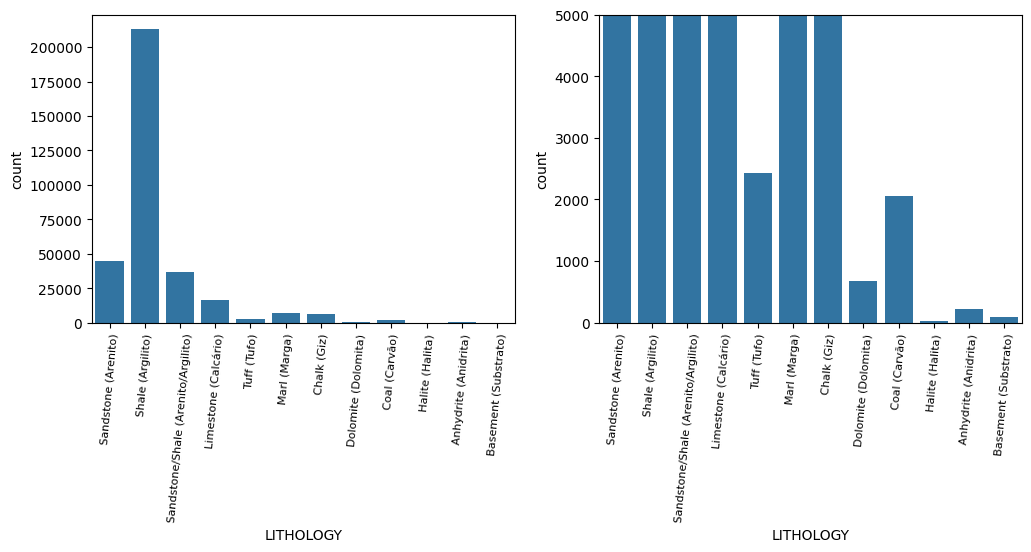

In [51]:
#### Fazendo a análise exploratória dos dados

#Verificando a distribuição das classes
fig,axes = plt.subplots(1,2,figsize=(12,4))
sns.countplot(x='LITHOLOGY', data=dataset,ax=axes[0])

axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=85,fontsize=8)

sns.countplot(x='LITHOLOGY', data=dataset,ax=axes[1])

axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=85,fontsize=8)
axes[1].set_ylim(0,5000)

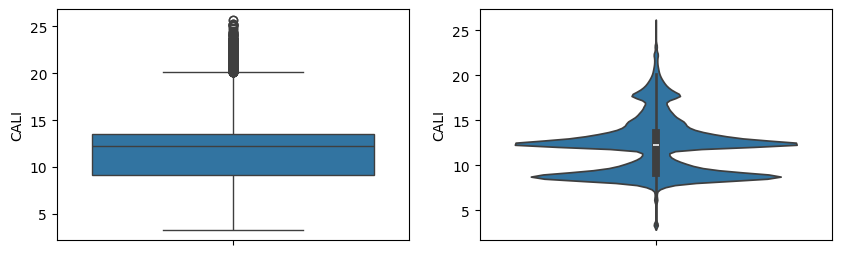

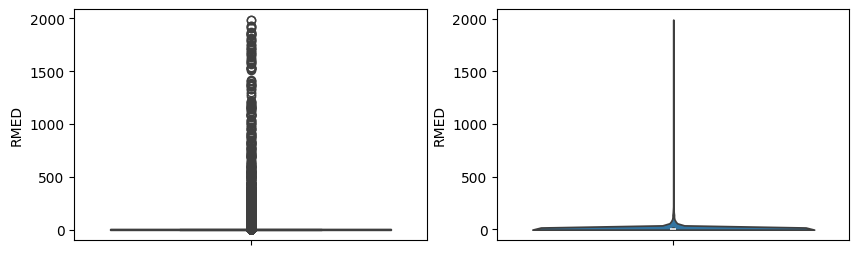

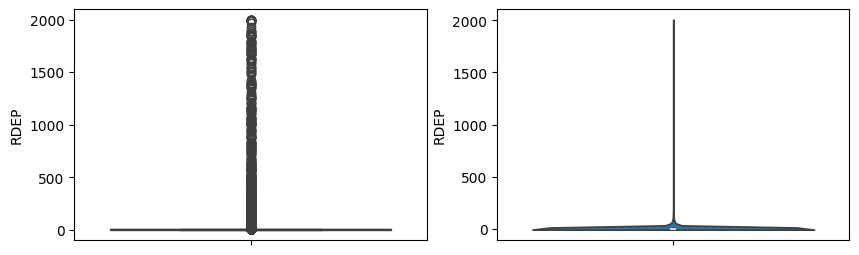

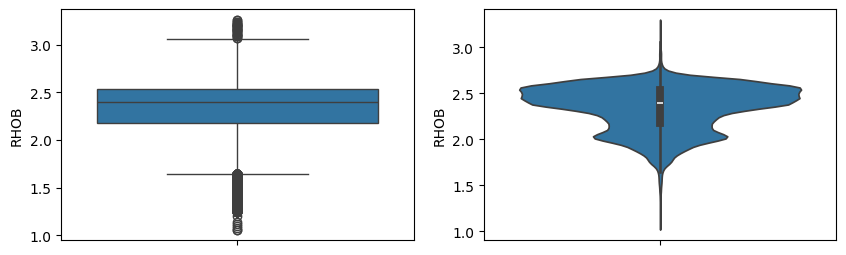

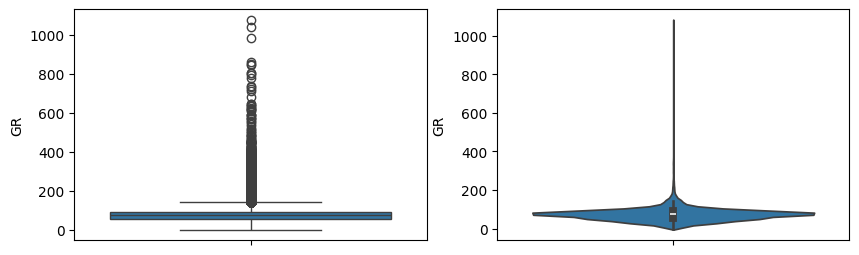

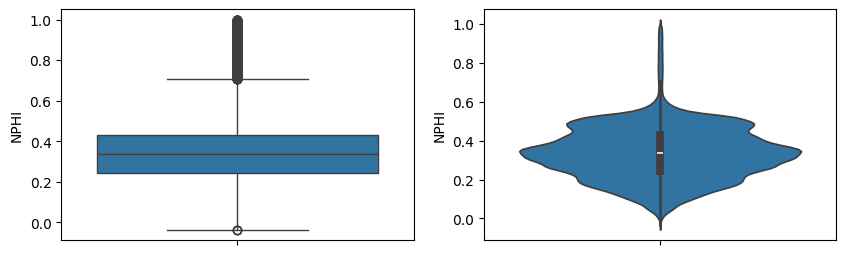

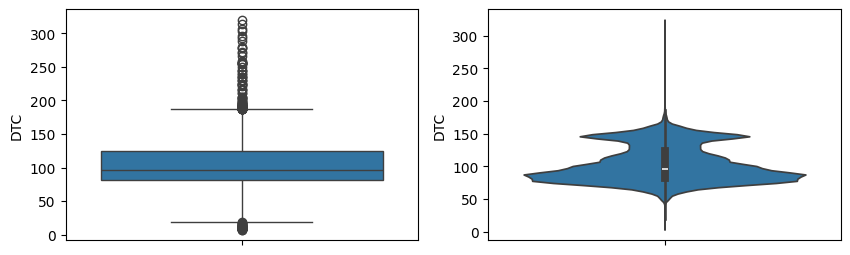

In [52]:
#Visualizando o boxplot das propriedades petrofísicas
cols = ['CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC']
for i in cols:
    fig,axes = plt.subplots(ncols=2,figsize=(10,3))
    sns.boxplot(y=i,data=dataset,ax=axes[0])
    sns.violinplot(y=i,data=dataset,ax=axes[1])
    fig.show()

In [53]:
#Aplicando o log em nos perfis de resistividade
dataset['RMED_log'] = np.log10(dataset['RMED'])
dataset['RDEP_log'] = np.log10(dataset['RDEP'])

#Aplicando o log em nos perfis de resistividade
blind['RMED_log'] = np.log10(blind['RMED'])
blind['RDEP_log'] = np.log10(blind['RDEP'])

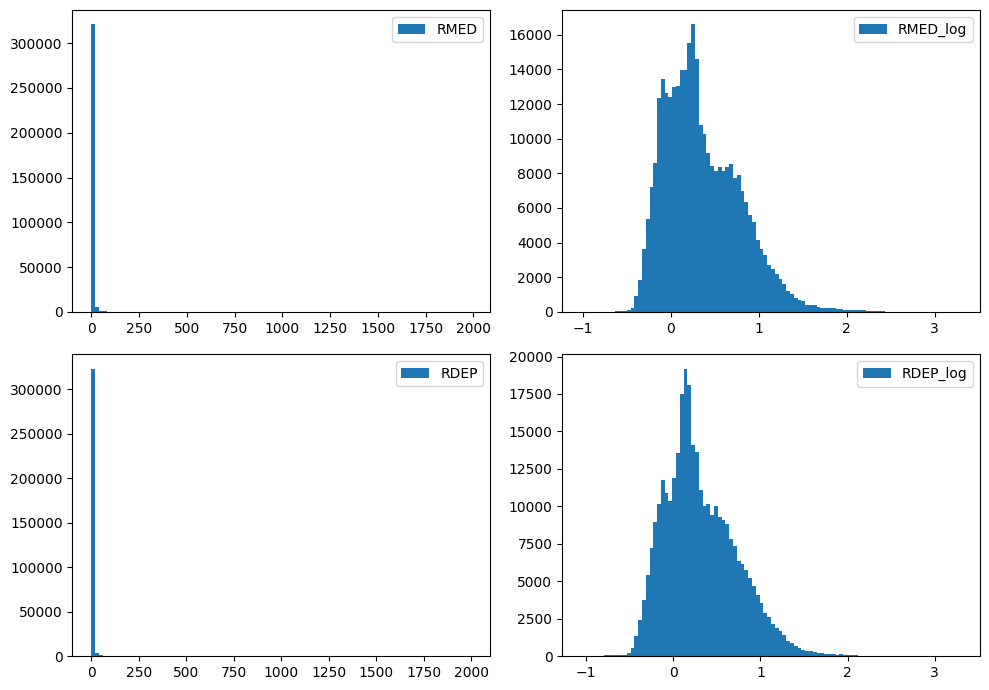

In [54]:
fig,axes = plt.subplots(2,2,figsize=(10,7))

axes[0][0].hist(dataset['RMED'],bins=100,label='RMED')
axes[0][1].hist(dataset['RMED_log'],bins=100,label='RMED_log')

axes[1][0].hist(dataset['RDEP'],bins=100,label='RDEP')
axes[1][1].hist(dataset['RDEP_log'],bins=100,label='RDEP_log')

for ax in axes:
    for ax1 in ax:
        ax1.legend()

fig.tight_layout()

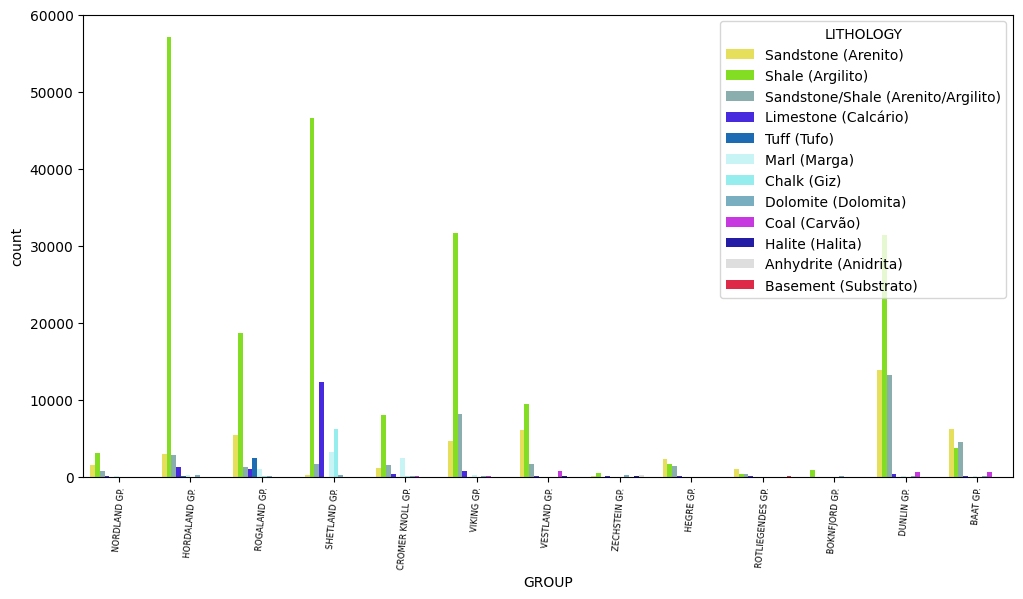

In [55]:
#Countplot das Formações com um hue=LITHOLOGY
fig,axes = plt.subplots(figsize=(12,6))

sns.countplot(x='GROUP', data=dataset,ax=axes,hue='LITHOLOGY',palette=colors)
axes.set_xticklabels(axes.get_xticklabels(), rotation=85,fontsize=6)

fig.show()

In [56]:
dataset.head()

,WELL,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP,GROUP_num,LITHOLOGY,RMED_log,RDEP_log
4238,15/9-13,1138.704,19.322735,1.013309,1.091499,1.774626,55.892757,0.765867,147.837677,30000,NORDLAND GP.,6,Sandstone (Arenito),0.005742,0.038023
4239,15/9-13,1138.856,18.613674,1.088184,1.122706,1.800986,60.929138,0.800262,142.382431,65000,NORDLAND GP.,6,Shale (Argilito),0.036703,0.050266
4240,15/9-13,1139.008,18.212072,1.127155,1.148141,1.817696,62.117264,0.765957,138.258331,65000,NORDLAND GP.,6,Shale (Argilito),0.051984,0.059995
4241,15/9-13,1139.160,18.134182,1.141467,1.170984,1.829333,61.010860,0.702521,139.198914,65000,NORDLAND GP.,6,Shale (Argilito),0.057463,0.068551
4242,15/9-13,1139.312,18.033762,1.138007,1.184080,1.813854,58.501236,0.639708,144.290085,65000,NORDLAND GP.,6,Shale (Argilito),0.056145,0.073381


In [57]:
#Salvando o dataset com novas variáveis
dataset.to_csv('/content/drive/MyDrive/train_dataset_proc.csv')
blind.to_csv('/content/drive/MyDrive/blind_dataset_proc.csv')